# Extracting wake and filtering it out of data

Restarting from the downsampled xrarray, extraction of active (without SWR) and quiet wake (with SWR) periods and removing these periods from the recordings.

## Setup everything

### Load packages

In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib widget

import HayLabAnalysis as hla

## Choose experiment and load data

In [ ]:
theExpe = hla.experiment()

Local config file loaded from localConfig.ini
current folder \\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\Claustrum\Expe_2024-07-31_17-29-39 contains a config file
\\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\Claustrum\Expe_2024-07-31_17-29-39


FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\Claustrum\Expe_2024-07-31_…

In [171]:
theExpe.analyseExpe_findData(fullSampling=False)

\\10.69.168.1\crnldata\waking\audrey_hay\NPX\interimAnalysis\NPX1\channelMaps.ini
Mapping found and loaded
{'EMG': [{'canal': '6', 'status': 1}], 'PFC': [{'canal': '21', 'status': 2}, {'canal': '20', 'status': 1}], 'OFC': [{'canal': '19', 'status': 2}, {'canal': '18', 'status': 1}], 'M2': [{'canal': '27', 'status': 2}, {'canal': '26', 'status': 1}], 'M1 -> DOWN States': [{'canal': '16', 'status': 2}, {'canal': '17', 'status': 1}], 'S1fl': [{'canal': '29', 'status': 2}, {'canal': '28', 'status': 1}], 'RSP': [{'canal': '30', 'status': 2}, {'canal': '31', 'status': 1}], 'CA1-1': [{'canal': '1', 'status': 2}, {'canal': '0', 'status': 1}], 'V1': [{'canal': '11', 'status': 2}, {'canal': '10', 'status': 1}], 'CA1-2': [{'canal': '2', 'status': 2}, {'canal': '3', 'status': 1}], 'S1bf': [{'canal': '14', 'status': 2}, {'canal': '15', 'status': 1}], 'mEC': [{'canal': '13', 'status': 2}, {'canal': '12', 'status': 1}]}
********found some RawDataChannelExtractedDS.npy files********
expeconfig exists 

c:\Users\Manip1\Documents\MB\HayLabAnalysis\.venv\Lib\site-packages\spikeinterface\core\baserecording.py:492: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warnings.warn(


## High pass filter

EMG -> [{'canal': '6', 'status': 1}]
Getting floating signal of channel 6 for EMG


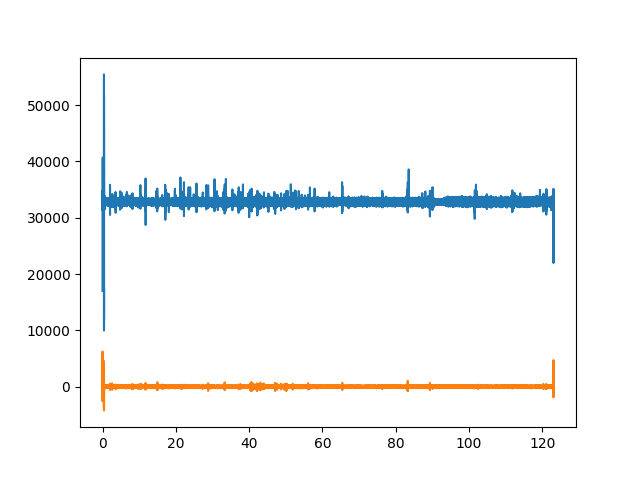

In [172]:
filt_EMG = theExpe.data['LFP_DS'].filterEMG()

## Sleep scoring
Continuous Wavelet Transform, projection calculation, and interpretating signal to extract wake (active and quiet) and sleep

EMG -> [{'canal': '6', 'status': 1}]
Getting floating signal of channel 6 for EMG


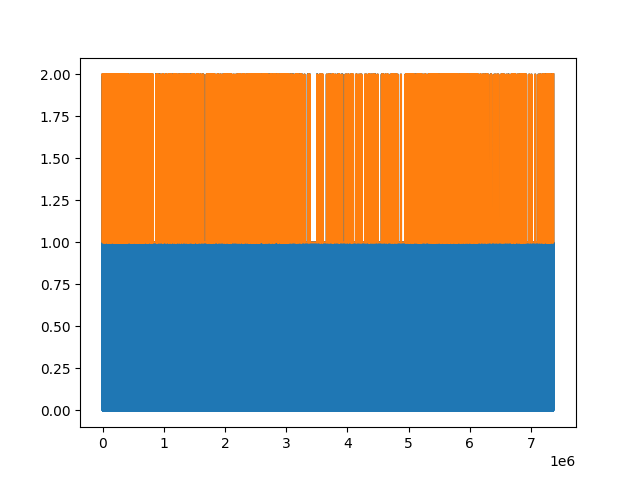

In [174]:
# there is an option to display the result, it is disactivated by default, it will allow me to get feedback to see if it is really used...
#TODO: save factors into experiment config
EMGstatusRaw2 = theExpe.data['LFP_DS'].sleep_scoring(low_cwt_factor=0.5, high_cwt_factor=3) #display = True

## To Create boolean masks and to save recordings without movement
#### Creating two masks: one conservative excludes weak muscular activity that can be quiet wake or dozing and one liberal that includes weak muscular activity

In [158]:
EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)

#### Removing wake time from the recordings.
Two files created one with 0 instead of signal during wake and one with the wake time removed

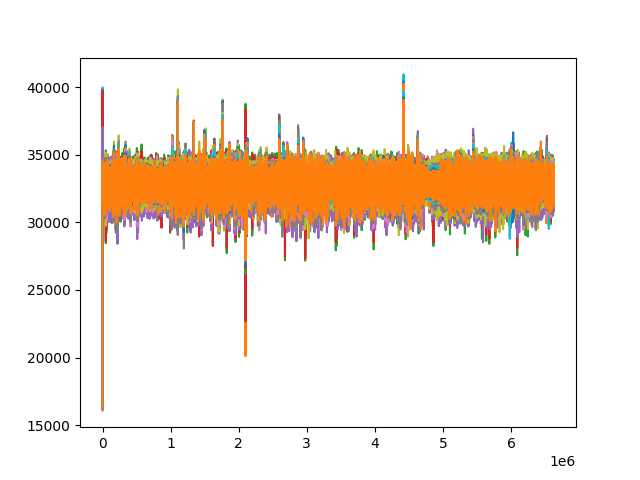

In [159]:
signal = np.load(os.path.join(theExpe.interim_analysis_path,'LFPwakeremoved.npy'), mmap_mode= 'r', allow_pickle=True)
plt.close()
plt.plot(signal)
plt.show()

In [ ]:
LFP = All[:,:]
LFPwake0 = LFP.copy()
LFPwake0[EMGStatusBoolLib] = 0

filename = os.path.join(dpath,f'LFPwake0{suffix}.npy')
np.save(filename, LFPwake0)

LFPwakeremoved = LFP.copy()
LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :]
filename = os.path.join(dpath,f'LFPwakeremoved{suffix}.npy')
np.save(filename, LFPwakeremoved)
data = {
    'EMGstatus': EMGstatusRaw2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative'])
filename = os.path.join(dpath,f'EMGframeBoolean{suffix}.pkl')

WakeFrame.to_pickle(filename)
# if done and no intention to display for assessment
#%reset
#plt.close('all')

In [ ]:
#filename = folder_base/ f'RawDataChannelExtractedDS.npy'
#np.save(filename, all)

In [ ]:
# Display on a subset (not a necessary step)
start = 1000
end = 2000

LFP = All[start:end, 1:4]
EMGStatusBoolLibt = EMGStatusBoolLib[start:end]
tt2 = tt[start:end]
EMGstatusRaw3 = EMGstatusRaw2[start:end]*2000
tentative = LFP.copy()

# to display LFP with wake time kept but signal set at 0
#tentative[EMGStatusBoolLibt] = 0
#plt.close('all')
#plt.plot(tt2, tentative)
#plt.plot(tt2, EMGstatusRaw3)
#plt.show()

# to display LFP with wake time removed.
tentative = tentative[~EMGStatusBoolLibt, :]
print(tentative.shape)
tt3 = tt[start:tentative.shape[0]]
plt.close('all')
plt.plot(tt3, tentative)
plt.show()
